<a href="https://colab.research.google.com/github/Erickrus/leetcode/blob/master/scorecard.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import math
import matplotlib.pyplot as plt
%matplotlib inline 
import pandas as pd
!pip3 install pandasql
import pandasql as pdsql
import numpy as np
from IPython.display import display, HTML


    100% |████████████████████████████████| 5.6MB 3.1MB/s 
  Running setup.py bdist_wheel for pandasql ... - \ done
  Stored in directory: /root/.cache/pip/wheels/53/6c/18/b87a2e5fa8a82e9c026311de56210b8d1c01846e18a9607fc9
  Running setup.py bdist_wheel for sqlalchemy ... - \ | / - \ | / - \ done
  Stored in directory: /root/.cache/pip/wheels/ed/bd/2e/d3874a6e97b8cc71e7e177c8d065ead30f67f380c4d9bbadaa
Successfully built pandasql sqlalchemy


In [2]:
!curl https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank.zip -o bank.zip && unzip bank.zip && ls -al bank*

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  565k  100  565k    0     0   403k      0  0:00:01  0:00:01 --:--:--  403k
Archive:  bank.zip
  inflating: bank-full.csv           
  inflating: bank-names.txt          
  inflating: bank.csv                
-rw-r--r-- 1 root root  461474 Feb 14  2012 bank.csv
-rw-r--r-- 1 root root 4610348 Feb 14  2012 bank-full.csv
-rw-r--r-- 1 root root    3864 Feb 14  2012 bank-names.txt
-rw-r--r-- 1 root root  579043 Oct 30 06:21 bank.zip


In [0]:
class Scorecard:
  # PDO - Points to double
  # https://zhuanlan.zhihu.com/p/29776029
  def __init__(self, P0, pointsToDouble, p):
    self.P0 = P0
    self.pointsToDouble = pointsToDouble
    self.p = p
    odds = p/(1.0-p)
    self.B = pointsToDouble / math.log(2.0)
    self.A = P0 + self.B * math.log(odds)
    
  def score(self, p):
    return self.A - self.B * math.log(p/(1-p))

In [0]:
class FeatureProcessor:
  def set_rowid(self, df):
    targetCol = "rowid"
    dfSize = len(df.index)
    df[targetCol] = pd.Series(np.linspace(1, dfSize, dfSize, dtype=np.int32), index = df.index)
    return df
  
  def even_bin(self, df, binCol, binSize):
    targetCol = "%s_bin" % binCol
    dfSize = len(df.index)

    
    df = df.sort_values([binCol], ascending=[True])
    
    
    df[targetCol] = pd.Series(
      np.ceil(
        np.linspace(
          1.0,
          float(dfSize) * float(binSize),
          float(dfSize)
        )/ float(dfSize)
      ), index = df.index)
    
      
    return df
    
      
  
  # formula taken from following link:
  # http://ucanalytics.com/blogs/information-value-and-weight-of-evidencebanking-case/
  def woe(self, df, binCol):
    totNumCol, badNumCol = "total_num", "bad_num"
    tmpDf = pdsql.sqldf("""
    SELECT
       %s,
       COUNT(1) AS total_num,
       SUM(CASE
          WHEN y='yes' THEN 1
          ELSE 0
       END) AS bad_num
    FROM df
    GROUP BY %s
    """ % (binCol, binCol))
    
    
    result = pd.DataFrame([], columns={
      "bin_id",
      "tot_num","tot_good_num","tot_bad_num",
      "all_num", "good_num","bad_num",
      "dist_good", "dist_bad",
      "weight_of_evidence", "info_val"})    
    totNum = tmpDf.loc[:,totNumCol].sum()
    badNum = tmpDf.loc[:,badNumCol].sum()
    goodNum = totNum - badNum
    
    for i in range(len(tmpDf.index)):
      distGood = (tmpDf.loc[:,totNumCol][i] - tmpDf.loc[:,badNumCol][i]) / totNum
      distBad = tmpDf.loc[:,badNumCol][i] / totNum
      result = result.append({
        "bin_id": tmpDf.loc[:,binCol][i],
        "tot_num": totNum,
        "tot_good_num": goodNum,
        "tot_bad_num": badNum,
        "all_num": tmpDf.loc[:,totNumCol][i],
        "good_num": (tmpDf.loc[:,totNumCol][i] - tmpDf.loc[:,badNumCol][i]),
        "bad_num": tmpDf.loc[:,badNumCol][i],
        "dist_good": distGood,
        "dist_bad": distBad,
        "weight_of_evidence": math.log(distGood / distBad), 
        "info_val":(distGood - distBad) * math.log(distGood / distBad)},
        ignore_index=True
      )
    iv = result.loc[:,"info_val"].sum()
    return result, iv
  
  def intepret_iv(self, iv):
    ivRange = [
      [0,    0.02, "Useless for prediction"],
      [0.02, 0.1,  "Weak predictor"],
      [0.1,  0.3,  "Medium predictor"],
      [0.3,  0.5,  "Strong predictor"],
      [0.5,  "+",  "Suspicious or too good to be true"]]
    for i in range(len(ivRange)):
      if i != len(ivRange)-1:
        if iv >= ivRange[i][0] and iv < ivRange[i][1]:
          return ivRange[i][2]
      else:
        if iv >= ivRange[i][0]:
          return ivRange[i][2]
    return "Invalid"

In [0]:
# https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank.zip
df = pd.read_csv("bank.csv", delimiter=";")
df2 = pdsql.sqldf("""
SELECT
   ROUND(age/10,0) bin,
   COUNT(1) AS total_num,
   SUM(CASE
      WHEN y='yes' THEN 1
      ELSE 0
   END) AS bad_num
FROM df
GROUP BY ROUND(age/10,0)
""")
df2.head(10)

In [13]:
df = pd.read_csv("bank.csv", delimiter=";")
df.head(10)



,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,79,1,-1,0,unknown,no
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220,1,339,4,failure,no
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,185,1,330,1,failure,no
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,199,4,-1,0,unknown,no
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,226,1,-1,0,unknown,no
5,35,management,single,tertiary,no,747,no,no,cellular,23,feb,141,2,176,3,failure,no
6,36,self-employed,married,tertiary,no,307,yes,no,cellular,14,may,341,1,330,2,other,no
7,39,technician,married,secondary,no,147,yes,no,cellular,6,may,151,2,-1,0,unknown,no
8,41,entrepreneur,married,tertiary,no,221,yes,no,unknown,14,may,57,2,-1,0,unknown,no
9,43,services,married,primary,no,-88,yes,yes,cellular,17,apr,313,1,147,2,failure,no


In [14]:
fp = FeatureProcessor()

# set bin for 2 fields - age, and duration
fp.set_rowid(df)
df = fp.even_bin(df, "age", 8)
df = fp.even_bin(df, "duration", 8)

df.head(10)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y,rowid,age_bin,duration_bin
1116,28,management,married,tertiary,no,318,yes,no,unknown,27,may,4,4,-1,0,unknown,no,1117,1.0,1.0
3933,39,services,single,secondary,no,471,no,no,unknown,15,oct,5,1,-1,0,unknown,no,3934,4.0,1.0
3566,35,services,married,secondary,no,181,yes,no,cellular,31,jul,5,3,-1,0,unknown,no,3567,3.0,1.0
1106,35,blue-collar,married,secondary,no,137,no,yes,unknown,4,oct,5,1,808,12,failure,no,1107,3.0,1.0
462,45,management,divorced,tertiary,no,0,no,no,unknown,1,jun,5,1,-1,0,unknown,no,463,6.0,1.0
3967,48,technician,married,secondary,no,10655,no,no,telephone,31,jul,5,3,-1,0,unknown,no,3968,6.0,1.0
2892,28,services,single,secondary,no,2685,no,yes,unknown,24,aug,5,1,-1,0,unknown,no,2893,1.0,1.0
2280,29,management,single,secondary,no,-105,yes,no,unknown,27,may,5,3,-1,0,unknown,no,2281,1.0,1.0
2218,58,blue-collar,married,primary,no,0,yes,no,cellular,31,jul,5,25,-1,0,unknown,no,2219,8.0,1.0
3408,38,management,single,tertiary,no,8669,yes,no,telephone,20,apr,5,3,150,6,failure,no,3409,4.0,1.0


,tot_num,dist_good,tot_bad_num,good_num,bad_num,dist_bad,all_num,bin_id,info_val,tot_good_num,weight_of_evidence
0,4521.0,0.106614,521.0,482.0,83.0,0.018359,565.0,1.0,0.155249,4000.0,1.759104
1,4521.0,0.112143,521.0,507.0,58.0,0.012829,565.0,2.0,0.215320,4000.0,2.168068
2,4521.0,0.111701,521.0,505.0,60.0,0.013271,565.0,3.0,0.209676,4000.0,2.130214
3,4521.0,0.112365,521.0,508.0,57.0,0.012608,565.0,4.0,0.218211,4000.0,2.187430
4,4521.0,0.114355,521.0,517.0,48.0,0.010617,565.0,5.0,0.246569,4000.0,2.376842
5,4521.0,0.111480,521.0,504.0,61.0,0.013493,565.0,6.0,0.206920,4000.0,2.111702
6,4521.0,0.111037,521.0,502.0,63.0,0.013935,565.0,7.0,0.201533,4000.0,2.075465
7,4521.0,0.105065,521.0,475.0,91.0,0.020128,566.0,8.0,0.140355,4000.0,1.652455


iv = 1.5938: Suspicious or too good to be true


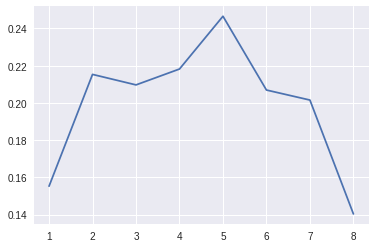

In [20]:


woeDf, iv = fp.woe(df, 'age_bin')
woeDf[["bin_id",
      "tot_num","tot_good_num","tot_bad_num",
      "all_num", "good_num","bad_num",
      "dist_good", "dist_bad",
      "weight_of_evidence", "info_val"]]
display(HTML(woeDf.to_html()))
print("iv = %2.4f: %s"%(iv, fp.intepret_iv(iv)))
plt.plot(woeDf.loc[:,"bin_id"], woeDf.loc[:,"info_val"])

,tot_num,dist_good,tot_bad_num,good_num,bad_num,dist_bad,all_num,bin_id,info_val,tot_good_num,weight_of_evidence
0,4521.0,0.124751,521.0,564.0,1.0,0.000221,565.0,1.0,0.788904,4000.0,6.335054
1,4521.0,0.121655,521.0,550.0,15.0,0.003318,565.0,2.0,0.426233,4000.0,3.601868
2,4521.0,0.121433,521.0,549.0,16.0,0.003539,565.0,3.0,0.416816,4000.0,3.535510
3,4521.0,0.118779,521.0,537.0,28.0,0.006193,565.0,4.0,0.332555,4000.0,2.953794
4,4521.0,0.114134,521.0,516.0,49.0,0.010838,565.0,5.0,0.243188,4000.0,2.354286
5,4521.0,0.108162,521.0,489.0,76.0,0.016810,565.0,6.0,0.170063,4000.0,1.861629
6,4521.0,0.100420,521.0,454.0,111.0,0.024552,565.0,7.0,0.106865,4000.0,1.408567
7,4521.0,0.075426,521.0,341.0,225.0,0.049768,566.0,8.0,0.010668,4000.0,0.415782


iv = 2.4953: Suspicious or too good to be true


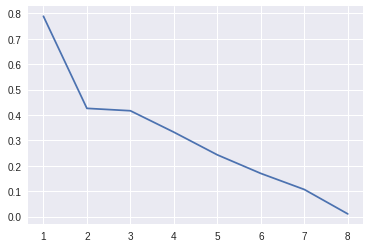

In [21]:
woeDf, iv = fp.woe(df, 'duration_bin')
woeDf[["bin_id",
      "tot_num","tot_good_num","tot_bad_num",
      "all_num", "good_num","bad_num",
      "dist_good", "dist_bad",
      "weight_of_evidence", "info_val"]]
display(HTML(woeDf.to_html()))
print("iv = %2.4f: %s"%(iv, fp.intepret_iv(iv)))
plt.plot(woeDf.loc[:,"bin_id"], woeDf.loc[:,"info_val"])